In [131]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from src.loading import *
from src.utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
def _compute_delta_pc(pcs, method, n=1, dt=3):
    if method=='centered':
        time_step = 2*n*dt
        pivot = 'mid'
        delta_pc_values = (
            pcs.isel(time=slice(2*n, None)).data -
            pcs.isel(time=slice(None, -2*n)).data
        )
        time_slice = slice(n, -(n))
    elif method=='forward':
        time_step = n*dt
        pivot = 'tail'
        delta_pc_values = (
            pcs.isel(time=slice(n, None)).data -
            pcs.isel(time=slice(None, -n)).data
        )
        time_slice = slice(None, -(n))
    elif method=='backwards':
        time_step = n*dt
        pivot = 'tip'
        delta_pc_values = (
            pcs.isel(time=slice(n, None)).data -
            pcs.isel(time=slice(None, -n)).data
        )
        time_slice = slice(n, None)
    
    return pcs.isel(time=time_slice).copy(data=delta_pc_values/time_step), pivot


# gSAM

In [125]:
pcs = load_gsam_eofs_pcs().scores()
pcs = pcs/pcs.std(('lat', 'lon', 'time'))
delta_pc, pivot = _compute_delta_pc(pcs, 'forward', n=1, dt=3)
pcs = pcs.sel(time=delta_pc.time)

In [128]:
pc_bins = np.arange(-10, 10, 0.5)
xmesh, ymesh = np.meshgrid(array_midpoints(pc_bins), array_midpoints(pc_bins))
obs_cutoff = 5
counts = binned_statistic_2d(
    pcs.sel(mode=2).data.ravel(), # y-coordinate data first
    pcs.sel(mode=1).data.ravel(), # x-coordinate data first
    None, 
    statistic='count',
    bins = [pc_bins, pc_bins]
).statistic

mean_delta_x = binned_statistic_2d(
    pcs.sel(mode=2).data.ravel(), # y-coordinate data first
    pcs.sel(mode=1).data.ravel(), # x-coordinate data first
    delta_pc.sel(mode=1).data.ravel(),
    statistic=lambda x: np.nanmean(x) if x.size>obs_cutoff else np.nan, 
    bins = [pc_bins, pc_bins]
).statistic

mean_delta_y = binned_statistic_2d(
    pcs.sel(mode=2).data.ravel(), # y-coordinate data first
    pcs.sel(mode=1).data.ravel(), # x-coordinate data first
    delta_pc.sel(mode=2).data.ravel(),
    statistic=lambda x: np.nanmean(x) if x.size>obs_cutoff else np.nan, 
    bins = [pc_bins, pc_bins]
).statistic



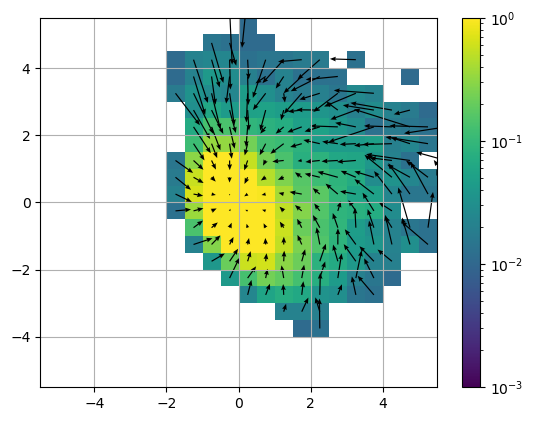

In [129]:
arrow_space=1
scale = 10
samp = (slice(None, None, arrow_space), slice(None, None, arrow_space))
fig, ax = plt.subplots()

c = ax.pcolormesh(
    xmesh,
    ymesh,
    np.ma.masked_array(100*counts/counts.sum(), mask=counts<obs_cutoff),
    norm=colors.LogNorm(vmin=1e-3, vmax=1e0),
    cmap=plt.cm.viridis.copy()
)

ax.quiver(
    xmesh[samp],
    ymesh[samp],
    mean_delta_x[samp],
    mean_delta_y[samp],
    angles='xy',
    pivot=pivot,
    scale=scale,
    width=0.003, headwidth=4, facecolor='black'

)
ax.grid()
ax.set_xlim(-5.5, 5.5)
ax.set_ylim(-5.5, 5.5)
fig.colorbar(c)

# ERA5 

In [135]:
pcs = load_era5_eofs_pcs().scores()
pcs = pcs/pcs.std(('latitude', 'longitude', 'time'))
delta_pc, pivot = _compute_delta_pc(pcs, 'forward', n=1, dt=3)
pcs = pcs.sel(time=delta_pc.time)